# Understanding KL-Divergence

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

### Goals:

Given probability distributions $p$ and $q$, find:

- G1: the divergence (measure of similarity) between them
- G2: assuming $p$ to be fixed, can we find optimum parameters of $q$ to make it as close as possible to $p$

Let us first look at G1. Look at the illustration below. We have a normal distribution $p$ and two other normal distributions $q_1$ and $q_2$. Which of $q_1$ and $q_2$, would we consider closer to $p$? $q_2$, right? To understand the notion of similarity, we use a metric called the KL-divergence given as $D_{KL}(a, b)$ where $a$ and $b$ are the two distributions. 



![](dkl.png)


![](kl_qp.gif)

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions
tfl = tfp.layers
tfb = tfp.bijectors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback
sns.reset_defaults()
sns.set_context(context='talk',font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [82]:
true_posterior = tfd.Normal(1, 4)

In [83]:
def create_surrogate_normal(loc, scale):
    return tfd.Normal(loc, scale)

In [84]:
q =  {}
q[(0, 1)] = create_surrogate_normal(0., 1.)

for loc in [0, 1, 2]:
    for scale in [1, 2]:
        q[(loc, scale)] = create_surrogate_normal(float(loc), float(scale))

In [85]:
z_values = tf.linspace(-5, 15, 200)
z_values = tf.cast(z_values, tf.float32)
prob_values_surrogate = q[(0, 1)].prob(z_values)
prob_values_true = true_posterior.prob(z_values)

Text(0, 0.5, 'PDF')

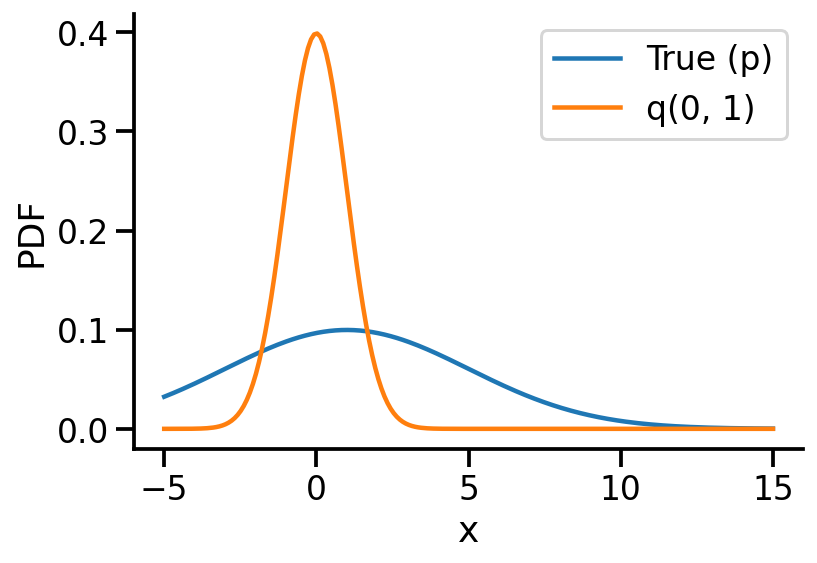

In [86]:
plt.plot(z_values, prob_values_true, label='True (p)')
plt.plot(z_values, prob_values_surrogate, label = 'q(0, 1)')
sns.despine()
plt.legend()
plt.xlabel("x")
plt.ylabel("PDF")

In [87]:
tfd.kl_divergence(q[(0, 1)], true_posterior)

<tf.Tensor: shape=(), dtype=float32, numpy=0.94879436>

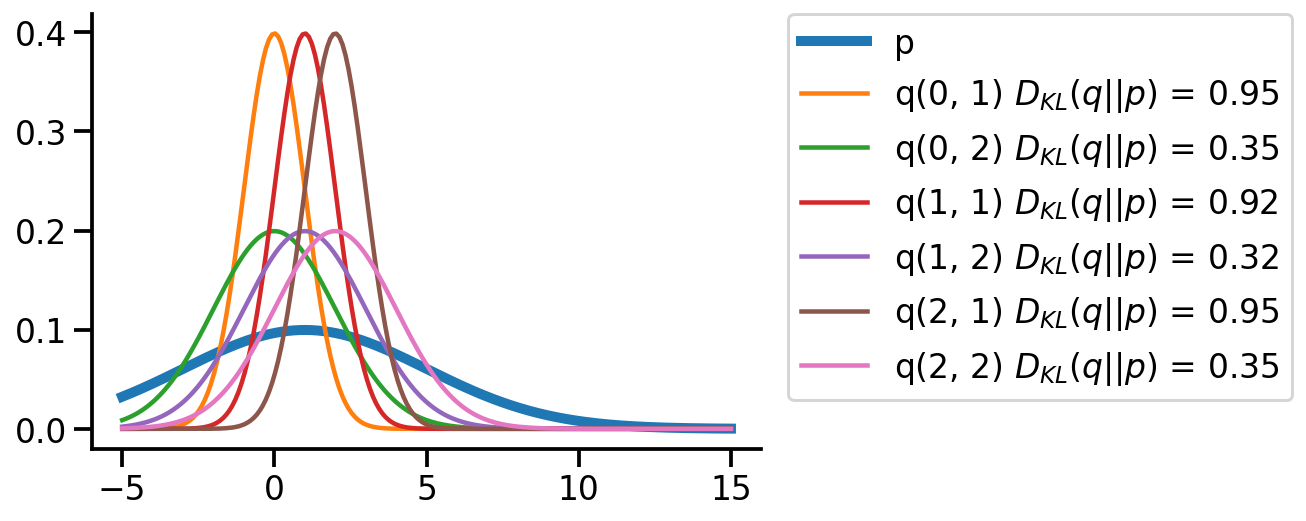

In [88]:
plt.plot(z_values, prob_values_true, label='p', lw=5)


for loc in [0, 1, 2]:
    for scale in [1, 2]:
        q_d = q[(loc, scale)]
        kl_d = tfd.kl_divergence(q[(loc, scale)], true_posterior)
        plt.plot(z_values, q_d.prob(z_values), label = fr'q({loc}, {scale}) $D_{{KL}}(q||p)$ = {kl_d:0.2f}')
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.xlabel("x")
plt.ylabel("PDF")
sns.despine()

In [137]:
to_train_q = tfd.Normal(loc = tf.Variable(-1., name='loc'),
                        scale = tfp.util.TransformedVariable(1., bijector=tfb.Exp(), name='scale'))

In [138]:
to_train_q.trainable_variables

(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=-1.0>,
 <tf.Variable 'scale:0' shape=() dtype=float32, numpy=0.0>)

In [139]:
@tf.function
def loss_and_grads(q_dist):
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(q_dist, true_posterior)
    return loss, tape.gradient(loss, q_dist.trainable_variables)

In [128]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

for i in range(500):
    loss, grads = loss_and_grads(to_train_q)
    optimizer.apply_gradients(zip(grads, to_train_q.trainable_variables))

In [129]:
to_train_q.loc,to_train_q.scale

(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=1.0>,
 <TransformedVariable: name=scale, dtype=float32, shape=[], fn="exp", numpy=4.0>)

In [221]:
from matplotlib import animation
fig = plt.figure(tight_layout=True, figsize=(8, 4))
ax = fig.gca()

to_train_q = tfd.Normal(loc = tf.Variable(5., name='loc'),
                        scale = tfp.util.TransformedVariable(0.1, bijector=tfb.Exp(), name='scale'))

def animate(i):
    ax.clear()
    ax.plot(z_values, prob_values_true, label=r'$p\sim\mathcal{N}(1.00, 4.00)$', lw=5)
    loss, grads = loss_and_grads(to_train_q)
    optimizer.apply_gradients(zip(grads, to_train_q.trainable_variables))
    loc = to_train_q.loc.numpy()
    scale = to_train_q.scale.numpy()
    
    ax.plot(z_values, to_train_q.prob(z_values), label=fr"$q\sim \mathcal{{N}}({loc:0.2f}, {scale:0.2f})$")
    d_kl = tfd.kl_divergence(to_train_q, true_posterior)
    
    ax.set_title(fr"Iteration: {i}, $D_{{KL}}(q||p)$: {d_kl:0.2f}")
    ax.legend(bbox_to_anchor=(1.1,1), borderaxespad=0)
    ax.set_ylim((0, 1))
    ax.set_xlim((-5, 15))


    ax.set_xlabel("x")
    ax.set_ylabel("PDF")
    sns.despine()
    
ani = animation.FuncAnimation(fig, animate, frames=150)
plt.close()


In [222]:
ani.save('kl_qp.gif', writer='imagemagick', fps=15, dpi=100)

<Figure size 432x288 with 0 Axes>

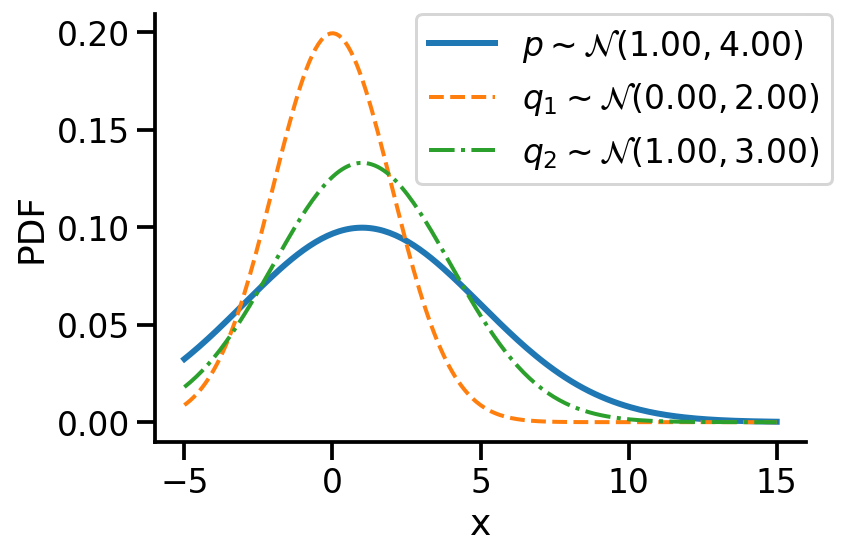

In [241]:
plt.plot(z_values, prob_values_true, label=r'$p\sim\mathcal{N}(1.00, 4.00)$', lw=3)
plt.plot(z_values, create_surrogate_normal(0., 2.).prob(z_values), 
         label=r'$q_1\sim\mathcal{N}(0.00, 2.00)$', lw=2, linestyle='--')
plt.plot(z_values, create_surrogate_normal(1., 3.).prob(z_values),
         label=r'$q_2\sim\mathcal{N}(1.00, 3.00)$', lw=2, linestyle='-.')

plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.xlabel("x")
plt.ylabel("PDF")
sns.despine()
plt.tight_layout()
plt.savefig("dkl.png", dpi=300, )

References


- https://www.youtube.com/watch?v=HUsznqt2V5I
- https://www.youtube.com/watch?v=x9StQ8RZ0ag&list=PLISXH-iEM4JlFsAp7trKCWyxeO3M70QyJ&index=9